# 🤖 AI vs Human Text Detection using Neural Networks

## Complete Tutorial from Basic to Advanced

This notebook demonstrates how to build neural networks for detecting whether text is AI-generated or human-written. We'll start with a basic model and progressively add advanced techniques like:

1. **Basic Neural Network** - Simple embedding + dense layers
2. **Dropout** - Regularization to prevent overfitting
3. **Batch Normalization** - Faster training and better stability
4. **Advanced Techniques** - LSTM, Bidirectional processing, L2 regularization

---

### 🎯 Learning Objectives:

- Understand text preprocessing and tokenization
- Build neural networks from scratch
- Learn about dropout and its importance
- Understand batch normalization
- Implement advanced architectures with LSTM
- Compare model performances

---


In [ ]:
# Install required packages (if needed)
# !pip install tensorflow scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 📁 Step 1: Load the Dataset

**For Google Colab:**

1. Upload your `ai_human_content_detection_dataset.csv` file using the file upload button in the left sidebar
2. Or mount your Google Drive if the file is stored there
3. Or download directly from a URL


In [ ]:
# Option 1: Upload file directly in Colab
# from google.colab import files
# uploaded = files.upload()

# Option 2: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/ai_human_content_detection_dataset.csv')

# Option 3: Load from uploaded file
df = pd.read_csv('ai_human_content_detection_dataset.csv')

df.head()


,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1
3,Story turn because such during open model. Tha...,creative_writing,196,1310,34,0.9592,5.76,5.69,0.0260,53.80,7.00,2,0.1912,88.79,0.6241,NaN,1
4,Place specific as simply leader fall analysis....,news_article,160,1115,28,0.9688,5.71,5.97,0.0251,44.53,8.29,0,0.1318,26.15,0.2894,NaN,1


DATASET EXPLORATION

Dataset shape: (1367, 17)

Columns: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']

First 3 samples:
                                        text_content  label
0  Score each cause. Quality throughout beautiful...      1
1  Board its rock. Job worker break tonight coupl...      1
2  Way debate decision produce. Dream necessary c...      1

Label distribution:
label
0    684
1    683
Name: count, dtype: int64


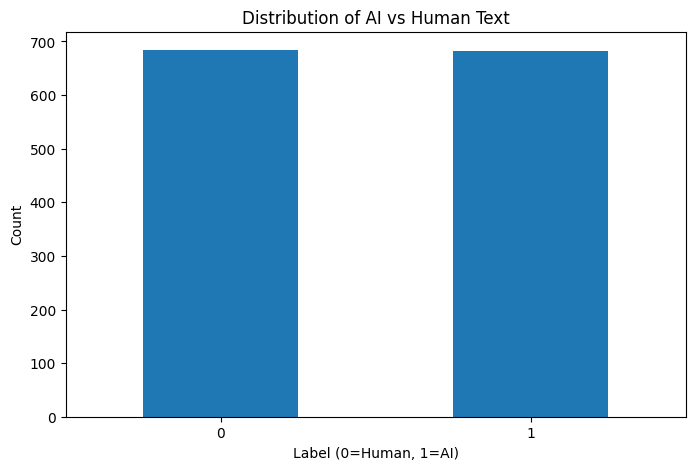

In [ ]:
print("="*80)
print("DATASET EXPLORATION")
print("="*80)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nFirst 3 samples:")
print(df[['text_content', 'label']].head(3))

print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize label distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of AI vs Human Text')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Extract features and labels
texts = df['text_content'].values
labels = df['label'].values

# Convert labels to binary if they're strings
if labels.dtype == 'object':
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    print(f"\nLabel mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    print(f"\nLabels are already numeric: {np.unique(labels)}")

# Split the data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Testing samples: {len(X_test_text)}")

DATA PREPROCESSING

Labels are already numeric: [0 1]

Training samples: 1093
Testing samples: 274


# 📝 Text Vectorization: Tokenization, Padding, and Embeddings

When we work with machine learning or deep learning models, we can’t feed them raw text (words, sentences). Models only understand **numbers**, so we need a way to convert text into numeric form. That’s what _text vectorization_ does.

Your code is an example of this process using **Keras Tokenizer + sequences + padding + embeddings**. Let’s break it down step by step.

---

## 1. Tokenization – turning words into numbers

Tokenization means **splitting text into words and assigning each word a unique number (ID)**.

Example:
Sentence → `"I love pizza"`
Tokenizer might map it as:

```
"I"     → 5
"love"  → 23
"pizza" → 11
```

So the sentence becomes:

```
[5, 23, 11]
```

👉 This keeps the **order of words**, unlike older methods like **Bag of Words** or **TF-IDF**.

---

## 2. Vocabulary size and OOV (Out of Vocabulary)

- We don’t always keep every single word (especially in large datasets).
- We often keep only the **top N most frequent words** (`MAX_WORDS` in your code).
- Rare or unseen words are replaced with a special token called **OOV (`<OOV>`)**.

Example:
If we only keep the **top 5,000 words** but the text contains a word like `"unicornpizza"` (never seen before), it will become:

```
["<OOV>"]
```

---

## 3. Sequences – keeping word order

After tokenization, each sentence becomes a list of integers called a **sequence**.

Example:

```
Text: "I love pizza so much"
Sequence: [5, 23, 11, 7, 19]
```

Unlike TF-IDF, which ignores order, **sequences preserve word order**, which is crucial for meaning.

---

## 4. Padding and Truncating – making all sentences the same length

Neural networks train in **batches**, and batches need inputs of the same size. But sentences can be short or long.

To fix this, we:

- **Pad** short sequences with zeros (usually at the end = `post` padding).
- **Truncate** long sequences by cutting extra words (often at the end).

Example (`max_length = 6`):

```
Original: [5, 23, 11]              →  [5, 23, 11, 0, 0, 0]   (padded)
Original: [9, 4, 6, 2, 8, 5, 10]   →  [9, 4, 6, 2, 8, 5]     (truncated)
```

Here `0` is the **padding token**.
This way, every sentence is the same length.

---

## 5. Embeddings – giving meaning to numbers

So far, words are just IDs like `[5, 23, 11]`. But **5, 23, 11** by themselves have no meaning.

👉 This is where **word embeddings** come in.

An **embedding** maps each word ID to a dense vector of real numbers (like 50, 100, or 300 dimensions). These vectors are **learned during training** and capture relationships between words.

Example (simplified, with 3-dimensional embeddings):

```
Word: "love"   → [0.25, 0.80, -0.33]
Word: "hate"   → [-0.20, -0.75, 0.40]
Word: "pizza"  → [0.10, 0.65, 0.55]
```

Notice how:

- Words with similar meanings (like `"love"` and `"like"`) get embeddings that are **close together** in this space.
- Words with opposite meanings (like `"love"` vs `"hate"`) may be far apart.

This is much more powerful than TF-IDF, because embeddings capture **semantic meaning** and can be used by deep learning models.

---

## 6. TF-IDF vs Embeddings (quick contrast)

- **TF-IDF**:

  - Large sparse vectors (one dimension per word).
  - Ignores order.
  - Doesn’t capture meaning beyond word counts.

- **Embeddings**:

  - Dense low-dimensional vectors (e.g., 100-D).
  - Preserve order when used in sequences.
  - Learn relationships between words.
  - Ideal for deep learning.

---

## ✅ Summary

- **Tokenization** → split text, assign numbers.
- **Sequences** → turn sentences into ordered lists of numbers.
- **Padding/Truncating** → make all sequences the same length.
- **Embeddings** → turn numbers into dense vectors that capture word meaning.

Your code does all these steps to prepare text for a neural network.


# 🎯 **The Embedding Layer: The Heart of Text Understanding in Neural Networks**

## 🤔 **What is an Embedding Layer?**

Imagine you're teaching a computer to read... but computers only understand numbers! The Embedding layer is like a **magical translator** that converts words into numbers that capture their meaning.

---

## 🎨 **Visual Representation**

```
Word: "love" → Index: 234 → Embedding Vector: [0.2, -0.5, 0.8, ..., 0.3] (128 dimensions)

Before Embedding:                After Embedding:
"I love AI"                      [[0.1, -0.3, 0.5, ...],    <- "I"
     ↓                            [0.2, -0.5, 0.8, ...],    <- "love"
[15, 234, 89]                     [0.7,  0.2, -0.1, ...]]   <- "AI"
(word indices)                    (128-dimensional vectors)
```

---

## 📚 **Why Do We Need Embeddings?**

### ❌ **Without Embeddings (One-Hot Encoding):**

```python
# Vocabulary of 10,000 words
"love" = [0, 0, 0, ..., 1, ..., 0, 0]  # 10,000 dimensions!
"like" = [0, 0, 1, ..., 0, ..., 0, 0]  # Also 10,000 dimensions!

# Problems:
# 1. HUGE vectors (10,000 dimensions each!)
# 2. No relationship captured (love ≈ like, but vectors are completely different)
# 3. All words are equally distant from each other
```

### ✅ **With Embeddings:**

```python
"love" = [0.2, -0.5, 0.8, ..., 0.3]  # Only 128 dimensions!
"like" = [0.21, -0.48, 0.79, ..., 0.31]  # Similar to "love"!
"hate" = [-0.3, 0.6, -0.7, ..., -0.2]  # Opposite direction!
```

---

## 🧮 **The Math Behind Embeddings**

### **Embedding Matrix:**

```
E = Embedding Matrix of shape (vocab_size × embedding_dim)
E = (10,000 × 128)

For word at index i:
embedding_vector = E[i, :]
```

### **Example Calculation:**

```python
# If MAX_WORDS = 10,000 and output_dim = 128
# Embedding matrix: 10,000 × 128 = 1,280,000 parameters

Word "happy" → Index 456
Embedding lookup: E[456] → [0.3, -0.2, 0.7, ..., 0.5] (128 values)
```

---

## 🏭 **Real Industry Examples**

### **1. Netflix Recommendations 🎬**

```python
# Movies are "embedded" into vectors
"Avengers" ≈ [action, superhero, blockbuster, ...]
"Iron Man" ≈ [action, superhero, tech, ...]  # Similar embedding!
"Titanic"  ≈ [romance, drama, historical, ...] # Different embedding!
```

### **2. Google Search 🔍**

```python
Query: "best Italian restaurant"
# Each word gets embedded:
"best"       → captures quality/ranking
"Italian"    → captures cuisine type
"restaurant" → captures venue type
# Combined embeddings help find relevant results!
```

### **3. ChatGPT/GPT Models 🤖**

```python
# GPT uses embeddings to understand context:
"bank" (financial) → [0.3, 0.8, -0.2, ...]
"bank" (river)     → [-0.5, 0.1, 0.7, ...]
# Same word, different meanings = different embeddings based on context!
```

---

## 🎯 **Breaking Down the Parameters**

```python
layers.Embedding(input_dim=10000,    # Size of vocabulary
                output_dim=128,       # Size of embedding vector
                input_length=200)     # Max sequence length
```

### **What Each Parameter Means:**

1. **`input_dim=10000`** 📖

   - Your vocabulary size (like a dictionary with 10,000 words)
   - Each word gets a unique ID from 0 to 9,999

2. **`output_dim=128`** 🎯

   - Each word becomes a 128-dimensional vector
   - Like describing each word with 128 features
   - Higher = more expressive but more memory

3. **`input_length=200`** 📏
   - Maximum sentence length (200 words)
   - Longer texts get truncated, shorter ones get padded

---

## 🔬 **What Happens During Training?**

```python
Initial (Random):
"good" = [0.23, -0.91, 0.45, ...]  # Random values
"great" = [-0.67, 0.12, -0.89, ...] # Very different!

After Training:
"good" = [0.65, 0.43, 0.21, ...]   # Learned values
"great" = [0.68, 0.41, 0.23, ...]  # Now similar! ✨
```

**The network learns that "good" and "great" appear in similar contexts, so it adjusts their embeddings to be closer!**

---

## 💡 **Semantic Relationships Captured**

After training, embeddings capture amazing relationships:

```python
# Word arithmetic works!
King - Man + Woman ≈ Queen
Paris - France + Japan ≈ Tokyo

# Similarity measurements
cosine_similarity("doctor", "physician") ≈ 0.95  # Very similar!
cosine_similarity("doctor", "banana") ≈ 0.05     # Not similar!
```

---

## 🚀 **Why This is Revolutionary**

### **Before Embeddings (Traditional NLP):**

- Treat words as isolated symbols ❌
- No understanding of meaning ❌
- Huge computational cost ❌

### **With Embeddings (Modern NLP):**

- Words have meaningful representations ✅
- Similar words are close in space ✅
- Efficient computation (128 dims vs 10,000) ✅
- Transfer learning possible ✅

---

## 🎮 **Interactive Example**

```python
# What the embedding layer does to your text:

Input text: "AI is amazing"
     ↓
Step 1: Tokenize
[89, 45, 234]  # Word indices
     ↓
Step 2: Embedding lookup
[[0.2, -0.3, 0.5, ..., 0.1],   # 89 → "AI" embedding
 [0.7,  0.1, -0.2, ..., 0.4],   # 45 → "is" embedding
 [0.3, -0.5,  0.8, ..., 0.6]]   # 234 → "amazing" embedding
     ↓
Step 3: To neural network
Now the network can process these meaningful numbers!
```

---

## 🎨 **Visualization of Embedding Space**

```
       Similar Context
            ↑
    "excellent" "great"
        *      *
"good" *          * "wonderful"

"bad" *            * "okay"
       *      *
   "terrible" "awful"
            ↓
       Different Context

(Words with similar meanings cluster together in embedding space!)
```

---

## 🏆 **Famous Pre-trained Embeddings**

1. **Word2Vec** (Google, 2013) - Revolutionized NLP
2. **GloVe** (Stanford, 2014) - Global vectors
3. **FastText** (Facebook, 2016) - Handles misspellings
4. **BERT** (Google, 2018) - Context-aware embeddings
5. **GPT** (OpenAI) - Powers ChatGPT!

---

## 📊 **Memory & Performance**

```python
# One-Hot Encoding:
Memory = 10,000 words × 10,000 dims × 4 bytes = 400 MB per sentence! 😱

# Embedding Layer:
Memory = 10,000 words × 128 dims × 4 bytes = 5.12 MB total! 😊
Speedup = 78x faster!
```

---

## 🎯 **Key Takeaways**

1. **Embeddings are learned** - They start random and improve during training
2. **Semantic meaning** - Similar words get similar vectors
3. **Dimensionality reduction** - From 10,000 to 128 dimensions
4. **Foundation of modern NLP** - Used in every text AI system today
5. **Transfer learning** - Can use pre-trained embeddings from other models

**Think of embeddings as teaching the computer the "GPS coordinates" of words in meaning-space! 🗺️**


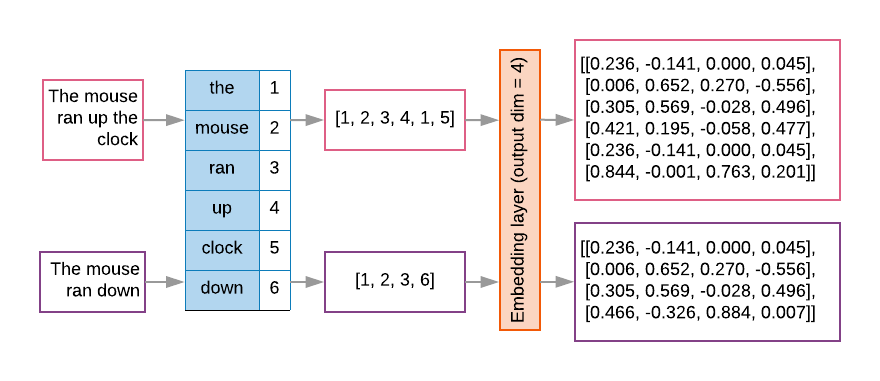


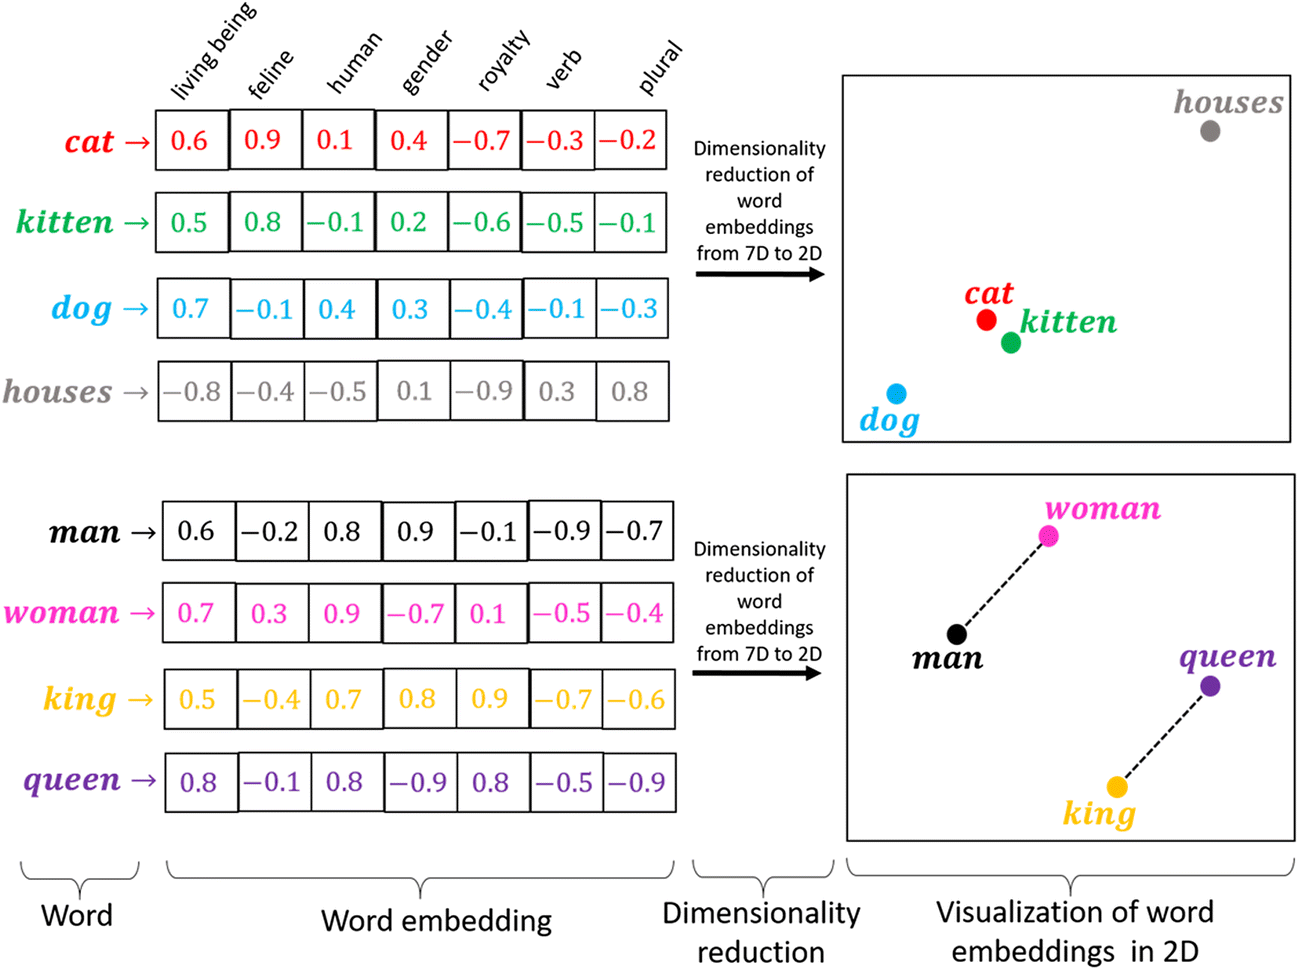


In [ ]:
print("="*80)
print("TEXT VECTORIZATION")
print("="*80)

# Set parameters
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LENGTH = 200    # Maximum length of sequences

print(f"\nParameters:")
print(f"- Max vocabulary size: {MAX_WORDS}")
print(f"- Max sequence length: {MAX_LENGTH}")

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequence shape: {X_train_padded.shape}")

# Show example of tokenization
example_text = X_train_text[0][:100]
example_seq = tokenizer.texts_to_sequences([example_text])[0]
print(f"\nExample text: '{example_text}...'")
print(f"Tokenized: {example_seq[:10]}...")

TEXT VECTORIZATION

Parameters:
- Max vocabulary size: 10000
- Max sequence length: 200

Vocabulary size: 972
Padded sequence shape: (1093, 200)

Example text: 'Listen information scene again. As the discussion water popular. Official pretty skin main program m...'
Tokenized: [341, 660, 205, 153, 272, 366, 554, 28, 273, 14]...


# 🔤 Explaining the Code: Text Vectorization

Let’s go step by step and understand what each part of the code does.

---

### 1. **Tokenizer**

```python
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)
```

- **Tokenizer**: Builds a dictionary of all words in your dataset.
- **num_words=MAX_WORDS**: Keep only the most common `10,000` words. Rare words are ignored.
- **oov_token='<OOV>'**: Any word not in the dictionary will be replaced with this special token.

✅ Example:
If your text is: `"I love pizza but not broccoli"`
It might become:

```
"I" → 5, "love" → 23, "pizza" → 11, "broccoli" → <OOV>
```

---

### 2. **texts_to_sequences**

```python
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)
```

- Converts each sentence into a **list of word IDs** (integers).
- Words are replaced by the number assigned in the vocabulary.
- Unknown words → `<OOV>` ID.

✅ Example:

```
Sentence: "I love pizza"
Sequence: [5, 23, 11]
```

---

### 3. **pad_sequences**

```python
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
```

- Neural networks need **equal-length inputs**.

- If a sentence is shorter than `MAX_LENGTH`, we **pad** it with zeros.

- If a sentence is longer, we **cut it (truncate)**.

- **padding='post'** → add zeros at the **end** of the sequence.

- **truncating='post'** → cut off extra words from the **end**.

✅ Example (maxlen=6):

```
Original: [5, 23, 11]
Padded:   [5, 23, 11, 0, 0, 0]

Original: [9, 4, 6, 2, 8, 5, 10]
Truncated:[9, 4, 6, 2, 8, 5]
```

---

### 4. **Vocabulary size**

```python
print(len(tokenizer.word_index))
```

- Shows how many **unique words** were found in your training data.
- This might be **more than MAX_WORDS** because the tokenizer records _all words_, but during training only the top `MAX_WORDS` will actually be used.

---

### 5. **Example text & tokenization**

```python
example_text = X_train_text[0][:100]
example_seq  = tokenizer.texts_to_sequences([example_text])[0]
```

- Takes the **first 100 characters** of the first training sentence.
- Converts it into a **tokenized sequence**.
- Good for checking how tokenization looks.

✅ Example output:

```
Example text: "This is my first review about the movie..."
Tokenized: [14, 3, 7, 52, 184, 9, 33, ...]
```

---

## 🎯 Summary of functions

- **Tokenizer** → Builds dictionary of words.
- **texts_to_sequences** → Turns text into lists of numbers.
- **pad_sequences** → Makes all sequences the same length (with zeros or truncation).
- **oov_token** → Marks unknown words.
- **padding='post'** → add zeros at the end.
- **truncating='post'** → cut off extra words at the end.


## 🔧 Model 1: Basic Neural Network

### Architecture Overview:

```
Input Text → Tokenization → Embedding → Flatten → Dense → Output
```

### Key Components:

1. **Embedding Layer**:

   - Converts word indices to dense vectors
   - Learns word representations during training
   - Input: (batch_size, sequence_length)
   - Output: (batch_size, sequence_length, embedding_dim)

2. **Flatten Layer**:

   - Converts 2D embedding output to 1D
   - Prepares data for dense layers

3. **Dense Layer**:

   - Fully connected neural network layer
   - ReLU activation for non-linearity

4. **Output Layer**:
   - Single neuron with sigmoid activation
   - Outputs probability (0-1) for binary classification


# 🔧 **The Flatten Layer: Reshaping Data for Dense Networks**

## 🤔 **What is a Flatten Layer?**

The Flatten layer is like a **data reorganizer** that takes multi-dimensional data and stretches it into a single long line - like unrolling a carpet! 🏠

---

## 🎨 **Visual Representation**

```
Before Flatten (2D):              After Flatten (1D):
┌─────────────┐
│ [0.1, 0.2]  │ word 1            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
│ [0.3, 0.4]  │ word 2     →      All values in a single row!
│ [0.5, 0.6]  │ word 3
└─────────────┘
Shape: (3, 2)                     Shape: (6,)
```

---

## 🎯 **Why Do We Need Flatten?**

### **The Problem:**

```python
# After Embedding layer:
Output shape: (batch_size, 200, 128)
             #            ↑    ↑
             #      sequence  embedding
             #       length    dims

# Dense layer expects:
Input shape: (batch_size, features)
            #             ↑
            #        single dimension!
```

**Dense layers can only handle 1D inputs (plus batch dimension), but embeddings give us 2D!**

---

## 📊 **Real Example with Numbers**

```python
# Your text after embedding:
embedded_text = [
    [[0.1, 0.2, 0.3],  # Word 1 embedding
     [0.4, 0.5, 0.6],  # Word 2 embedding
     [0.7, 0.8, 0.9]]  # Word 3 embedding
]
# Shape: (1, 3, 3) = (batch, sequence_length, embedding_dim)

# After Flatten:
flattened = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Shape: (1, 9) = (batch, flattened_features)

# Now Dense layer can process it! ✅
```

---

## 🧮 **The Math Behind Flatten**

```python
Input shape:  (batch_size, 200, 128)
Output shape: (batch_size, 200 × 128)
Output shape: (batch_size, 25,600)

# No parameters to learn! It's just reshaping:
Parameters = 0
```

### **Mathematical Operation:**

```
Flatten(X) = reshape(X, [batch_size, -1])
where -1 means "figure out this dimension automatically"
```

---

## 🎮 **Interactive Example**

```python
# Let's trace through your model:

"I love AI"
    ↓
[15, 234, 89] (tokenized)
    ↓
Embedding (MAX_LENGTH=200, embedding_dim=128)
    ↓
Shape: (200, 128)  # 200 words × 128 features each
    ↓
🔧 FLATTEN HAPPENS HERE 🔧
    ↓
Shape: (25,600)  # 200 × 128 = 25,600 features
    ↓
Dense layer can now process these 25,600 features!
```

---

## 🏭 **Real-World Analogy**

### **📚 Library Book Organization**

```
Before Flatten (Organized Shelves):
Shelf 1: [Book1, Book2, Book3]
Shelf 2: [Book4, Book5, Book6]
Shelf 3: [Book7, Book8, Book9]

After Flatten (Moving Day):
Box: [Book1, Book2, Book3, Book4, Book5, Book6, Book7, Book8, Book9]

All books in one long box for transport!
```

---

## ⚖️ **Flatten vs Other Options**

### **1. Flatten (What we're using)**

```python
layers.Flatten()
# Pros: Simple, preserves all information
# Cons: Creates very large vectors (25,600 dimensions!)
# Use case: When you want ALL the information
```

### **2. Global Average Pooling** ⭐

```python
layers.GlobalAveragePooling1D()
# Input: (200, 128) → Output: (128)
# Takes average across sequence dimension
# Pros: Much smaller output, less overfitting
# Cons: Loses positional information
```

### **3. Global Max Pooling**

```python
layers.GlobalMaxPooling1D()
# Input: (200, 128) → Output: (128)
# Takes maximum across sequence dimension
# Pros: Captures strongest signals
# Cons: Loses most information
```

---

## 💡 **Why Flatten Can Be Problematic**

```python
# Your current model:
Embedding: (200, 128) → Flatten → (25,600)
                                      ↑
                            That's a LOT of features!

# Problems:
1. 🐌 Computational cost (Dense layer needs 25,600 × 64 = 1.6M parameters!)
2. 📈 Overfitting risk (too many parameters)
3. 💾 Memory usage
4. 🔄 Loses sequence structure
```

---

## 🚀 **Modern Alternatives to Flatten**

```python
# Instead of Flatten → Dense, modern models use:

1. LSTM/GRU (Processes sequences naturally)
   "I love AI" → LSTM → Final hidden state

2. Attention Mechanisms (Transformer models)
   "I love AI" → Self-Attention → Weighted combination

3. CNN + Pooling (For text classification)
   "I love AI" → Conv1D → MaxPool → Dense
```

---

## 📊 **Performance Impact**

```python
# With Flatten:
Parameters after: 25,600 × 64 + 64 = 1,638,464 params 😱

# With GlobalAveragePooling1D:
Parameters after: 128 × 64 + 64 = 8,256 params 😊

# Reduction: 198× fewer parameters!
```

---

## 🎨 **Visualization**

```
FLATTEN OPERATION:

   2D Matrix                    1D Vector
   ┌─────────┐
   │ █ █ █ █ │ row 1           ████████████████
   │ ▓ ▓ ▓ ▓ │ row 2      →    (all values in sequence)
   │ ░ ░ ░ ░ │ row 3
   └─────────┘

Think of it like:
- Reading a book page: left→right, top→bottom
- Unwinding a roll of paper
- Straightening a coiled rope
```

---

## 🔬 **What Happens to Sequence Information?**

```python
Original structure:
Word 1: [features...]
Word 2: [features...]
Word 3: [features...]
# Clear sequence order ✅

After Flatten:
[word1_feat1, word1_feat2, ..., word2_feat1, word2_feat2, ..., word3_feat1, ...]
# Sequence order preserved but structure lost ⚠️
```

---

## 🎯 **Key Takeaways**

1. **No Learning** - Flatten has 0 parameters, it just reshapes
2. **Dimensionality Explosion** - 200×128 = 25,600 features!
3. **Simple but Costly** - Easy to understand but computationally expensive
4. **Better Alternatives Exist** - GlobalPooling, LSTM, Attention
5. **Still Useful** - Good for simple models and learning basics

### **🏆 Pro Tip:**

For text classification, replace:

```python
layers.Flatten()  # 25,600 dimensions
```

With:

```python
layers.GlobalAveragePooling1D()  # Only 128 dimensions!
```

You'll get similar accuracy with 200× fewer parameters! 🚀

---

## 💭 **Think of Flatten as...**

"Taking a neatly organized 2D spreadsheet and copying all cells into one long row - you keep all the data, but lose the structure!" 📊➡️📝


# 🧮 **Math Behind Global Pooling Operations**

## 📊 **Global Average Pooling (GAP)**

### **Mathematical Formula:**

```
For input X with shape (sequence_length, features):
GAP(X) = (1/sequence_length) × Σ(X[i]) for i = 0 to sequence_length-1
```

### **Example with Numbers:**

```python
# Input: (3 words, 4 features each)
X = [[1, 2, 3, 4],    # Word 1
     [5, 6, 7, 8],    # Word 2
     [9, 10, 11, 12]] # Word 3

# Global Average Pooling:
Output = [(1+5+9)/3, (2+6+10)/3, (3+7+11)/3, (4+8+12)/3]
Output = [5.0, 6.0, 7.0, 8.0]

# Shape: (3, 4) → (4)
```

### **Visual:**

```
Column-wise averaging:
     ↓    ↓    ↓    ↓
   [[1,   2,   3,   4],
    [5,   6,   7,   8],
    [9,  10,  11,  12]]
     ↓    ↓    ↓    ↓
   [5.0, 6.0, 7.0, 8.0]
```

---

## 🚀 **Global Max Pooling (GMP)**

### **Mathematical Formula:**

```
For input X with shape (sequence_length, features):
GMP(X) = max(X[i]) for i = 0 to sequence_length-1
```

### **Example with Numbers:**

```python
# Input: (3 words, 4 features each)
X = [[1, 2, 3, 4],    # Word 1
     [5, 6, 7, 8],    # Word 2
     [9, 10, 11, 12]] # Word 3

# Global Max Pooling:
Output = [max(1,5,9), max(2,6,10), max(3,7,11), max(4,8,12)]
Output = [9, 10, 11, 12]

# Shape: (3, 4) → (4)
```

### **Visual:**

```
Column-wise maximum:
     ↓    ↓    ↓    ↓
   [[1,   2,   3,   4],
    [5,   6,   7,   8],
    [9,  10,  11,  12]]
     ↓    ↓    ↓    ↓
    [9,  10,  11,  12]
```

---

## 🎯 **In Your Model Context:**

```python
# Your embedding output: (200, 128)
# 200 words, each with 128-dimensional embedding

# Global Average Pooling:
For each of 128 features:
    average_feature[j] = sum(all 200 words' j-th feature) / 200
Result: 128 averaged features

# Global Max Pooling:
For each of 128 features:
    max_feature[j] = maximum(all 200 words' j-th feature)
Result: 128 maximum values
```

---

## 💡 **Intuition:**

**Global Average Pooling:** "What's the average sentiment/meaning across the entire text?"

- Like getting the overall mood of a conversation

**Global Max Pooling:** "What's the strongest signal in the text?"

- Like finding the loudest voice in a room

---

## 📈 **Why This Reduces Parameters:**

```python
Flatten:           200 × 128 = 25,600 features → Dense(64) = 1,638,464 params
Global Pooling:    128 features → Dense(64) = 8,256 params

Reduction: 198× fewer parameters! 🎉
```


# 🧠 **Dense Layer: The Fundamental Building Block**

## **What is a Dense Layer?**

A Dense layer (also called **Fully Connected Layer** or **FC Layer**) is a neural network layer where **every input neuron connects to every output neuron**.

### **Mathematical Definition:**

```
y = f(Wx + b)

Where:
- x: input vector (n dimensions)
- W: weight matrix (m × n dimensions)
- b: bias vector (m dimensions)
- f: activation function
- y: output vector (m dimensions)
```

---

## **How Dense Layer Works: Step by Step**

### **Example: Dense(3) with 2 inputs**

```python
Input: x = [x₁, x₂] = [0.5, 0.3]

Weight Matrix W:
[[w₁₁, w₁₂],    [[0.2, 0.4],
 [w₂₁, w₂₂],  =  [0.1, 0.3],
 [w₃₁, w₃₂]]     [0.5, 0.2]]

Bias: b = [b₁, b₂, b₃] = [0.1, 0.2, 0.3]

Calculation for each neuron:
Neuron 1: (0.5×0.2) + (0.3×0.4) + 0.1 = 0.1 + 0.12 + 0.1 = 0.32
Neuron 2: (0.5×0.1) + (0.3×0.3) + 0.2 = 0.05 + 0.09 + 0.2 = 0.34
Neuron 3: (0.5×0.5) + (0.3×0.2) + 0.3 = 0.25 + 0.06 + 0.3 = 0.61

Output (before activation): [0.32, 0.34, 0.61]
```

---

## **Why "Dense" or "Fully Connected"?**

It's called "Dense" because the connection matrix is **dense** (opposite of sparse):

```
Sparse Connection:          Dense Connection:
Input → Output              Input → Output
  1  →  1                     1  →  1,2,3
  2  →  2                     2  →  1,2,3
  3  →  3                     3  →  1,2,3
(Only some connections)     (ALL possible connections)
```

---

## **Parameters in Dense Layer**

### **Formula:**

```
Total Parameters = (input_size × output_size) + output_size
                   \_____________________/     \________/
                          Weights                Biases
```

### **Your Model Example:**

```python
layers.Dense(64, activation='relu')  # Input: 25,600
Parameters = (25,600 × 64) + 64 = 1,638,464
```

---

## **What Dense Layer Learns**

Each neuron in a Dense layer learns to detect specific patterns:

```python
# Conceptual Example (Text Classification):
Neuron 1: Detects positive sentiment words
Neuron 2: Detects formal language patterns
Neuron 3: Detects technical terminology
...
Neuron 64: Detects conclusion phrases

# These patterns are encoded in the weights!
```

---

## **Interview Question Examples:**

**Q: Why do we need bias in Dense layers?**

```
A: Bias allows the activation function to shift. Without bias,
   the hyperplane always passes through origin, limiting expressiveness.

   With bias:    y = wx + b  (can shift line up/down)
   Without bias: y = wx      (always passes through 0,0)
```

**Q: Can a Dense layer have more outputs than inputs?**

```
A: Yes! Common in encoder architectures.
   Example: Dense(128) with 64 inputs = expanding representation
   Parameters: 64 × 128 + 128 = 8,320
```

---

# ⚡ **ReLU Activation: The Non-Linear Hero**

## **What is ReLU?**

**ReLU (Rectified Linear Unit)** is an activation function that introduces non-linearity:

```
f(x) = max(0, x)
```

### **Simple Implementation:**

```python
def relu(x):
    return x if x > 0 else 0

# Vectorized:
def relu(x):
    return np.maximum(0, x)
```

---

## **Why Do We Need Activation Functions?**

Why We Need Activation Functions
Without activation functions, stacking multiple Dense layers would be pointless. Here's why:
The Problem of Linearity:
Imagine you're trying to separate red and blue dots on a paper. If you can only draw straight lines, some patterns are impossible to separate. But if you can bend and curve your decision boundary, suddenly complex patterns become separable.
Without activation: Can only draw straight lines
With ReLU activation: Can create complex, bent decision boundaries
What Makes ReLU Special?
ReLU stands for Rectified Linear Unit, and it's beautifully simple:
If input is positive: Let it through unchanged
If input is negative: Block it (output zero)
Think of it as a one-way valve in plumbing - water flows freely in one direction but is completely blocked in the other.

### **Without Activation (Linear):**

```python
Layer 1: y₁ = W₁x + b₁
Layer 2: y₂ = W₂y₁ + b₂
Final:   y₂ = W₂(W₁x + b₁) + b₂ = W₂W₁x + W₂b₁ + b₂

# This is still linear! Just y = Wx + b
# Can't learn complex patterns!
```

### **With ReLU:**

```python
Layer 1: y₁ = ReLU(W₁x + b₁)
Layer 2: y₂ = ReLU(W₂y₁ + b₂)

# Non-linear! Can approximate any function!
```

---

## **ReLU's Mathematical Properties**

### **1. Derivative (Gradient):**

```
ReLU'(x) = {1  if x > 0
           {0  if x ≤ 0

# Simple gradient = faster backpropagation!
```

### **2. Non-Saturating:**

```
Unlike sigmoid/tanh, ReLU doesn't saturate for positive values:
- Sigmoid saturates at 0 and 1
- Tanh saturates at -1 and 1
- ReLU: No upper bound! Linear for x > 0
```

### **3. Sparsity:**

```python
Input:  [-2, 0.5, -1, 3, -0.1, 2]
Output: [ 0, 0.5,  0, 3,  0,   2]
# 50% sparsity - efficient computation!
```

---

## **The Vanishing Gradient Problem (Why ReLU Wins)**

### **With Sigmoid:**

```
σ(x) = 1/(1 + e^(-x))
σ'(x) = σ(x)(1 - σ(x))

Maximum gradient: σ'(0) = 0.25

In deep networks:
Layer 1: gradient × 0.25
Layer 2: gradient × 0.25 × 0.25 = gradient × 0.0625
Layer 3: gradient × 0.25³ = gradient × 0.015625
...
Layer 10: gradient × 0.25¹⁰ ≈ gradient × 0.0000009

Gradient vanishes! No learning in early layers!
```

### **With ReLU:**

```
Layer 1: gradient × 1
Layer 2: gradient × 1
...
Layer 10: gradient × 1

Gradient preserved! All layers learn!
```

---

## **Common ReLU Variants**

### **1. Leaky ReLU**

```python
f(x) = x if x > 0 else 0.01x

# Prevents "dying ReLU" problem
# Small gradient for negative values
```

## **Practical Code Example**

```python
import numpy as np

# Implement Dense layer with ReLU from scratch
class DenseLayer:
    def __init__(self, input_size, output_size):
        # Initialize weights (He initialization for ReLU)
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2/input_size)
        self.b = np.zeros((output_size, 1))

    def forward(self, x):
        # Linear transformation
        z = np.dot(self.W, x) + self.b
        # ReLU activation
        a = np.maximum(0, z)
        return a

    def relu_derivative(self, x):
        return (x > 0).astype(float)

# Usage
layer = DenseLayer(input_size=3, output_size=2)
input_data = np.array([[0.5], [0.3], [0.8]])
output = layer.forward(input_data)
print(f"Output shape: {output.shape}")  # (2, 1)
```

---

## **Key Takeaways for Interviews**

1. **Dense Layer** = Linear transformation (Wx + b) where every input connects to every output
2. **ReLU** = max(0, x) - simple but powerful non-linearity
3. **Why ReLU**: Solves vanishing gradient, computationally efficient, creates sparse networks
4. **Parameters**: Dense(m) with n inputs = n×m + m parameters
5. **Gradient**: ReLU gradient is 1 or 0, preserves gradient magnitude in backprop


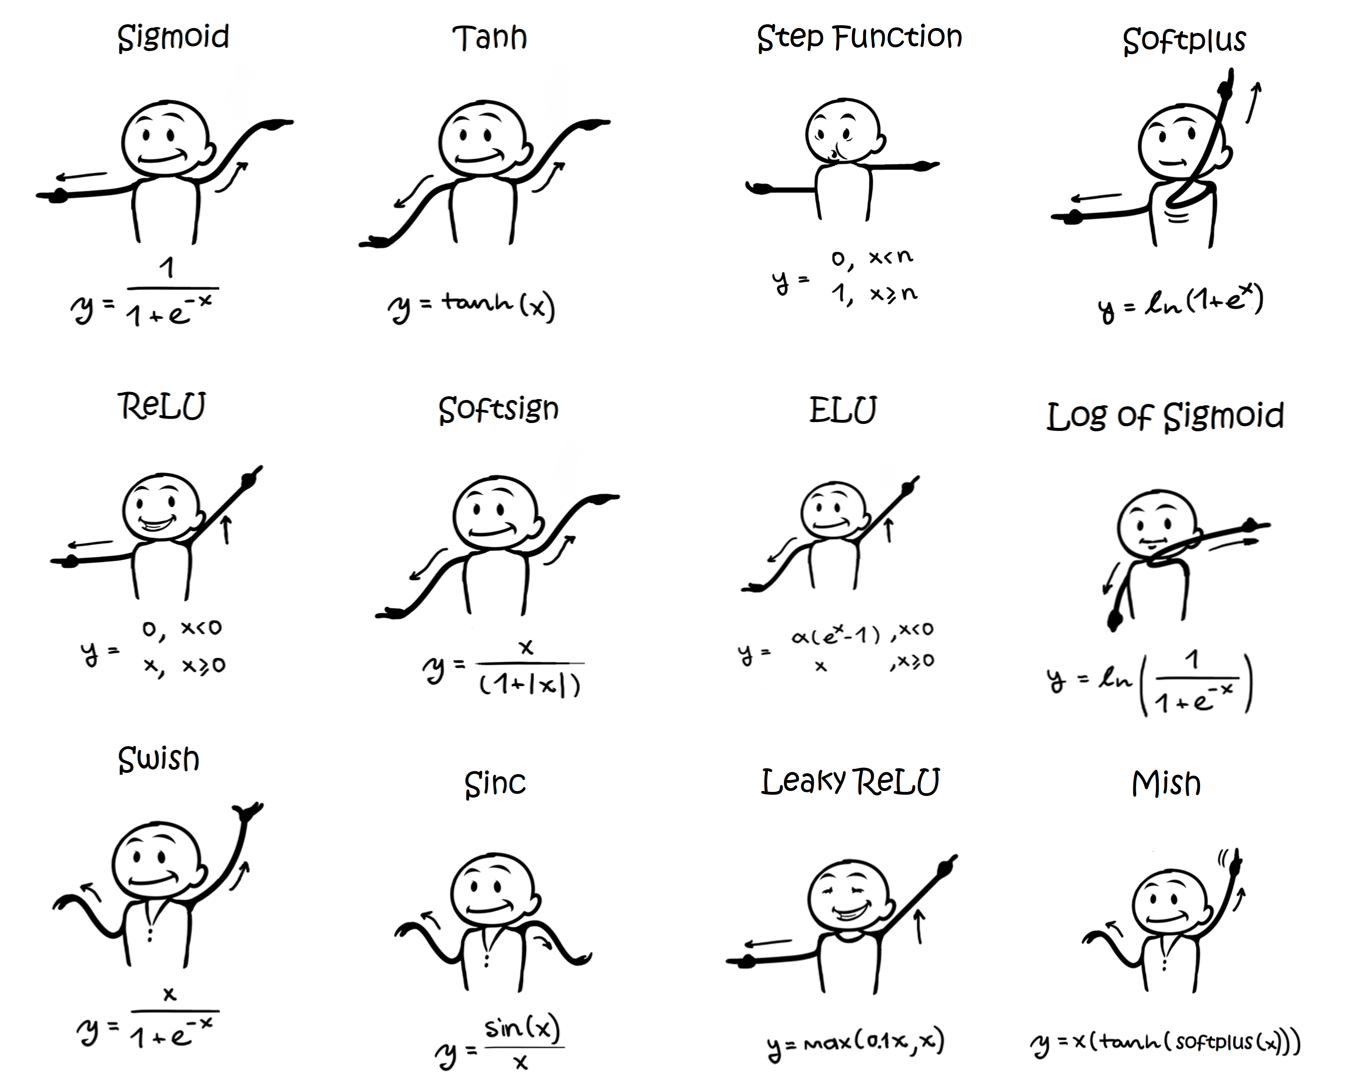


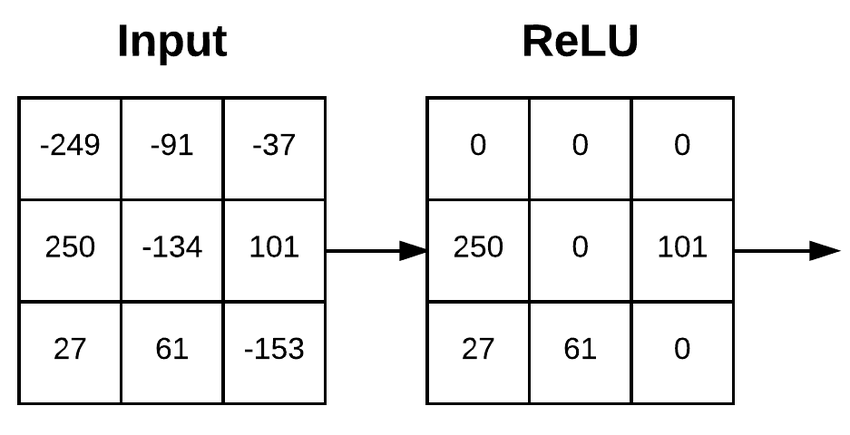


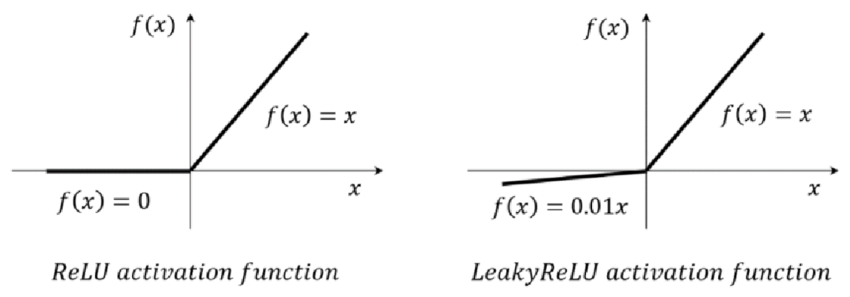


# 🔨 **What Does `model.build()` Do?**

## **The Problem It Solves**

When you create a Sequential model in TensorFlow/Keras, it starts in an **"unbuilt" state** - it doesn't know the shapes of its layers yet. The model is like a blueprint waiting to be constructed.

```python
model.build(input_shape=(None, MAX_LENGTH))
```

## **What This Line Does**

This line **explicitly builds the model** by telling it the shape of input data it will receive:

- **`input_shape=(None, MAX_LENGTH)`**
  - `None` = Batch size (can be any number - 1, 32, 64, etc.)
  - `MAX_LENGTH` = Sequence length (200 in your case)

## **What Happens During Build**

```python
Before build():
- Model doesn't know input dimensions
- Can't calculate output shapes
- Weights are not created
- Shows "?" in model.summary()

After build():
- Model knows all layer dimensions
- Creates weight matrices
- Calculates parameters
- Shows actual shapes in model.summary()
```

## **Example**

```python
# Without build - model is incomplete
model = create_basic_model()
model.summary()  # Shows "?" for shapes, 0 parameters

# With build - model is ready
model.build(input_shape=(None, 200))
model.summary()  # Shows actual shapes, 2.9M parameters
```

## **Why Not Automatic?**

TensorFlow uses **lazy building** - it waits until it knows the input shape. This happens automatically when:

- You pass data through the model (`model.fit()` or `model.predict()`)
- You explicitly call `model.build()`

## **The Bottom Line**

`model.build()` transforms your model from a **blueprint** to an **actual constructed network** with allocated weights and defined shapes. It's like telling a construction crew "the foundation is this size, now build the house!"

Without this line, your model would still build automatically on first use, but calling it explicitly lets you see the architecture immediately with `model.summary()`.


# 🏔️ **Gradient Descent: Finding the Lowest Point in the Valley**

## **The Mountain Hiking Analogy**

Imagine you're **lost in foggy mountains at night** and need to reach the valley (lowest point). You can't see far, but you can feel the slope under your feet.

**Your strategy:**

1. Feel which direction slopes downward
2. Take a step in that direction
3. Repeat until you reach the bottom

**This is exactly what Gradient Descent does!**

---

## 🎯 **What is Gradient Descent?**

Gradient Descent is an algorithm to find the **minimum of a function** (in our case, the loss function).

**The Goal:** Find the weights that give us the lowest error (loss).

### **Simple Real-Life Example**

You're trying to find the perfect recipe for coffee:

- **Too weak** (less coffee) = Bad taste (high loss)
- **Too strong** (more coffee) = Bad taste (high loss)
- **Just right** = Perfect taste (minimum loss)

Gradient descent helps find that "just right" amount!

---

## 📐 **The Mathematics - Made Simple**

### **What is a Gradient?**

A gradient is just a **fancy word for slope**:

- Positive gradient = Going uphill ↗️
- Negative gradient = Going downhill ↘️
- Zero gradient = Flat ground →

### **The Core Formula**

```
new_position = current_position - learning_rate × gradient

Or in terms of weights:
new_weight = old_weight - learning_rate × gradient
```

**Why minus?** Because gradient points uphill, but we want to go downhill!

---

## 🎨 **Visual Example: Finding the Best Weight**

Let's say we have ONE weight to optimize:

```
Loss Function: L = (weight - 3)²
Goal: Find weight that minimizes L

   Loss
    ^
   10|     *
    8|    * *
    6|   *   *
    4|  *     *
    2| *       *
    0|*_________*_____ weight
     0 1 2 3 4 5 6
         ↑
     Minimum at weight=3
```

---

## 📊 **Step-by-Step Example**

Let's find the minimum of **L = (w - 3)²**

### **Mathematical Steps:**

```python
# Starting point
weight = 5.0  # We start with a random guess
learning_rate = 0.1

# Iteration 1
# Step 1: Calculate loss
Loss = (5 - 3)² = 4

# Step 2: Calculate gradient (derivative)
gradient = dL/dw = 2(w - 3) = 2(5 - 3) = 4

# Step 3: Update weight
weight = 5.0 - 0.1 × 4 = 5.0 - 0.4 = 4.6

# Iteration 2
Loss = (4.6 - 3)² = 2.56
gradient = 2(4.6 - 3) = 3.2
weight = 4.6 - 0.1 × 3.2 = 4.28

# Iteration 3
Loss = (4.28 - 3)² = 1.64
gradient = 2(4.28 - 3) = 2.56
weight = 4.28 - 0.1 × 2.56 = 4.024

# And so on... approaching 3!
```

### **What's Happening?**

- We're getting closer to 3 (the minimum) with each step!
- The gradient (slope) gets smaller as we approach the minimum
- Steps become smaller near the bottom (self-adjusting!)

---

## 🎮 **Interactive Visualization**

```
Starting at weight=5:

Step 1: w=5.0   Loss=4.00   [--------*--]  Far from minimum!
Step 2: w=4.6   Loss=2.56   [------*----]  Getting closer...
Step 3: w=4.28  Loss=1.64   [-----*-----]  Better!
Step 4: w=4.02  Loss=1.05   [----*------]  Almost there!
Step 5: w=3.62  Loss=0.38   [---*-------]  Very close!
...
Step 20: w≈3.0  Loss≈0.00   [---★-------]  Found it! ⭐
```

---

## 🧮 **Gradient Descent in Neural Networks**

In your text classification model, we're not optimizing 1 weight, but **2.9 million weights!**

### **The Loss Landscape**

Instead of a 2D curve, imagine a **2.9-million-dimensional landscape**:

```
Each weight is a dimension:
- weight₁: Word "the" importance
- weight₂: Word "AI" importance
- weight₃: Word "generated" importance
... 2.9 million more!

Loss = How wrong our predictions are on all training examples
```

### **The Process:**

```python
For each training batch:
1. Forward pass: Make predictions with current weights
2. Calculate loss: How wrong were we?
3. Backward pass: Calculate gradient for EACH weight
4. Update: Move each weight in direction that reduces loss
```

---

## 💡 **Your Model's Gradient Descent**

Let's trace through your actual model:

```python
# Your model predicting "AI" vs "Human" text

# Forward Pass
Input: "This text seems artificial"
Current prediction: 0.3 (thinks it's human)
True label: 1 (actually AI)
Loss: 0.7 (we're very wrong!)

# Backward Pass (calculates gradients)
∂Loss/∂weight_for_"artificial" = +0.5  # This word suggests AI!
∂Loss/∂weight_for_"seems" = +0.1       # Weak signal
∂Loss/∂weight_for_"text" = 0.0         # Neutral word

# Update Weights
weight_"artificial" = old - 0.001 × 0.5 = increases AI detection
weight_"seems" = old - 0.001 × 0.1 = slightly increases
weight_"text" = unchanged
```

---

## 🚀 **Learning Rate: The Speed Control**

### **Too Small (0.00001):**

```
Step 1: weight = 5.0000
Step 2: weight = 4.9999
Step 3: weight = 4.9998
...
Step 10000: weight = 4.5  (Still far from 3!)
😴 Takes forever!
```

### **Just Right (0.1):**

```
Step 1: weight = 5.0
Step 2: weight = 4.6
Step 3: weight = 4.28
...
Step 20: weight ≈ 3.0  ✅ Perfect!
```

### **Too Large (10):**

```
Step 1: weight = 5.0
Step 2: weight = 5 - 10×4 = -35  (Overshot!)
Step 3: weight = -35 - 10×(-76) = 725  (Way overshot!)
💥 Explodes!
```

---

## 🎯 **Real Example: Training Your Model**

```python
Epoch 1, Batch 1:
- Text: "AI generated this"
- Model thinks: 30% AI (wrong!)
- Calculate gradient: "Need to increase AI weights"
- Update: Nudge weights toward recognizing AI patterns

Epoch 1, Batch 2:
- Text: "I love pizza"
- Model thinks: 20% AI (correct, it's human!)
- Calculate gradient: "Good job, small adjustment"
- Update: Tiny changes

After 1000 batches:
- Model has seen patterns thousands of times
- Weights have been nudged in right direction repeatedly
- Now accurately distinguishes AI vs Human!
```

---

## 🌟 **The Magic of Gradients**

### **Why Does This Work?**

The gradient tells us **two critical things**:

1. **Direction**: Which way to adjust the weight (+ or -)
2. **Magnitude**: How much to adjust (large or small error)

### **Automatic Gradient Calculation**

You don't calculate these by hand! TensorFlow uses **backpropagation**:

```python
# TensorFlow does this automatically:
with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = loss_function(predictions, labels)

gradients = tape.gradient(loss, model.weights)
# Magic! All 2.9 million gradients calculated!
```

---

## 📈 **Gradient Descent Variants**

### **1. Batch Gradient Descent**

```
Use ALL data to calculate gradient
Pro: Accurate gradient
Con: Slow for large datasets

Like: Surveying everyone in the country before making a decision
```

### **2. Stochastic Gradient Descent (SGD)**

```
Use ONE example to calculate gradient
Pro: Fast updates
Con: Noisy, zigzag path

Like: Asking one person and immediately acting on it
```

### **3. Mini-Batch Gradient Descent** (What you use!)

```
Use SMALL BATCH (32 examples) to calculate gradient
Pro: Balance of speed and accuracy
Con: Need to choose batch size

Like: Surveying a small focus group - practical!
```

---

## 🎨 **Beautiful Visualization**

```
Loss Surface (2D projection of your 2.9M dimensional space):

     High Loss (Bad predictions)
            ⛰️
         ⛰️    ⛰️
      ⛰️          ⛰️
    ⛰️              ⛰️
   ⛰️     Start→ •    ⛰️
  ⛰️         ↘︎        ⛰️
 ⛰️           •→•      ⛰️
⛰️              ↘︎      ⛰️
                 •→★
            (Minimum found!)
     Low Loss (Good predictions)

Each • is one gradient descent step
```

---

## 🔑 **Key Insights**

1. **Gradient = Slope = Direction to improve**
2. **Learning Rate = Step size = How fast we move**
3. **Iteration = Taking steps = Getting closer to minimum**
4. **Minimum = Best weights = Accurate predictions**

### **The Beautiful Simplicity:**

```
Repeat until happy:
1. Check which way is downhill (gradient)
2. Take a small step that way (learning rate)
3. Check if we're at the bottom (loss)
```

---

## 💭 **Final Intuition**

**Gradient Descent is like teaching a child to ride a bike:**

- **First attempts**: Wobbly, lots of corrections (large gradients)
- **Getting better**: Smaller corrections needed (smaller gradients)
- **Mastery**: Tiny adjustments to stay balanced (near minimum)

In your model, gradient descent is teaching the network:

- Which words indicate AI text
- Which patterns are human-like
- How to combine 2.9 million signals into one decision

**Every batch of text you show it, it gets a little bit better!**

---

Ready to see how **Adam optimizer** makes this even smarter? It's like gradient descent with a GPS and cruise control! 🚀


In [ ]:
def create_basic_model():
    """
    Create a basic neural network model.
    """
    model = models.Sequential([
        # Embedding layer: converts word indices to dense vectors
        layers.Embedding(input_dim=MAX_WORDS,
                        output_dim=128,
                        input_length=MAX_LENGTH),

        # Flatten the 2D embedding to 1D
        layers.Flatten(),

        # Hidden layer with ReLU activation
        layers.Dense(64, activation='relu'),

        # Output layer with sigmoid for binary classification
        layers.Dense(1, activation='sigmoid')


    ])


    model.build(input_shape=(None, MAX_LENGTH))
    return model

# Create and compile the model
basic_model = create_basic_model()

basic_model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Basic Model Architecture:")
basic_model.summary()

Basic Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918,529 (11.13 MB)

 Trainable params: 2,918,529 (11.13 MB)

 Non-trainable params: 0 (0.00 B)

## 📊 Understanding Parameter Calculation in Neural Networks

### How Parameters are Calculated:

**Parameters = Weights + Biases**

Let's break down each layer:

### 1️⃣ **Embedding Layer**: 1,280,000 parameters

```
Parameters = vocab_size × embedding_dim
Parameters = 10,000 × 128 = 1,280,000
```

- We have 10,000 words (MAX_WORDS)
- Each word gets a 128-dimensional vector
- Think of it as a lookup table: 10,000 rows × 128 columns

### 2️⃣ **Flatten Layer**: 0 parameters

```
Just reshapes data, doesn't learn anything
Input: (200, 128) → Output: (25,600)
200 sequence length × 128 embedding dim = 25,600 flat features
```

### 3️⃣ **Dense Layer 1**: 1,638,464 parameters

```
Parameters = (input_size × output_size) + bias
Parameters = (25,600 × 64) + 64
Parameters = 1,638,400 + 64 = 1,638,464
```

- Weights: 25,600 inputs × 64 neurons = 1,638,400
- Biases: 1 per neuron = 64

### 4️⃣ **Dense Layer 2 (Output)**: 65 parameters

```
Parameters = (64 × 1) + 1
Parameters = 64 + 1 = 65
```

- Weights: 64 inputs × 1 output = 64
- Bias: 1

### **Total**: 2,918,529 parameters

```
1,280,000 + 0 + 1,638,464 + 65 = 2,918,529
```

### 💡 **Simple Analogy**:

- **Embedding**: Dictionary with 10,000 words, each defined by 128 features
- **Dense Layer**: Every input connects to every output (fully connected)
- **Parameters**: The "knobs" the model adjusts during training to learn patterns

**Memory**: ~11.13 MB (each parameter is 4 bytes in float32)


Training Basic Model...
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4619 - loss: 0.6940 - val_accuracy: 0.4886 - val_loss: 0.6929
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5058 - loss: 0.6931 - val_accuracy: 0.4795 - val_loss: 0.6933
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5382 - loss: 0.6921 - val_accuracy: 0.4749 - val_loss: 0.6936
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5536 - loss: 0.6911 - val_accuracy: 0.4840 - val_loss: 0.6938
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5659 - loss: 0.6901 - val_accuracy: 0.4795 - val_loss: 0.6940
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5881 - loss: 0.6891 - val_accuracy: 0.4749 - val_loss: 0.6941
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6002 - loss: 0.6880 - val_accuracy: 0.4840 - val_loss: 0.6942
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6149 - loss: 0.6870 - 

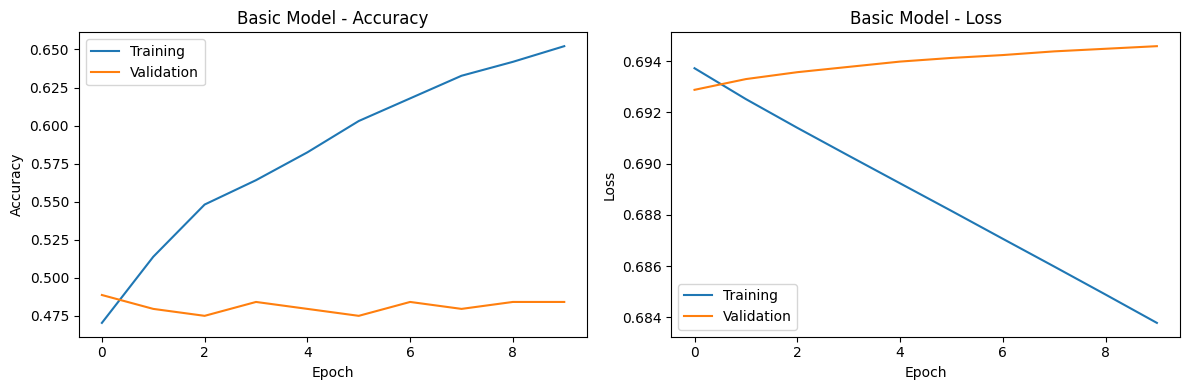

In [ ]:
# Train the basic model
print("Training Basic Model...")
print("="*50)

history_basic = basic_model.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
print("\nEvaluating Basic Model...")
basic_predictions = (basic_model.predict(X_test_padded) > 0.5).astype(int).flatten()
basic_accuracy = accuracy_score(y_test, basic_predictions)

print(f"\n{'='*50}")
print(f"Basic Model Test Accuracy: {basic_accuracy:.4f}")
print(f"{'='*50}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_basic.history['accuracy'], label='Training')
plt.plot(history_basic.history['val_accuracy'], label='Validation')
plt.title('Basic Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['loss'], label='Training')
plt.plot(history_basic.history['val_loss'], label='Validation')
plt.title('Basic Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 🎲 **Dropout: The Power of Random Deactivation**

## **What is Dropout?**

Dropout is a regularization technique where we **randomly "turn off" neurons** during training. It's like randomly removing team members during practice to make the remaining members stronger and more versatile.

---

## 🎯 **The Overfitting Problem**

### **Without Dropout - The Memorization Issue**

Imagine a student preparing for an exam:

- **Bad approach**: Memorizes exact questions and answers
- **Problem**: Fails when questions are slightly different
- **Result**: Great on practice tests, terrible on real exam

This is **overfitting** - your model memorizes training data instead of learning patterns.

---

## 🧠 **How Dropout Works**

### **Training Phase: Random Deactivation**

```python
During each training batch:
1. Randomly select neurons to "drop" (typically 50%)
2. Set their outputs to 0
3. Train remaining network
4. Next batch: Different neurons dropped

Example with Dropout(0.5):
Batch 1: Neurons [1,3,5,7] active, [2,4,6,8] dropped
Batch 2: Neurons [2,3,6,8] active, [1,4,5,7] dropped
Batch 3: Neurons [1,2,5,6] active, [3,4,7,8] dropped
```

### **Testing Phase: All Neurons Active**

```python
During testing/inference:
1. ALL neurons are active
2. Output scaled by dropout rate
3. Ensemble effect of many sub-networks

Testing: All neurons [1,2,3,4,5,6,7,8] active
Output multiplied by (1 - dropout_rate)
```

---

## 📊 **Visual Representation**

### **Training Time:**

```
Original Network:          With Dropout (p=0.5):

    ●  ●  ●  ●                ●  ○  ●  ○
   /|\/|\/|\/|\              /│\   /│\
  ● ● ● ● ● ● ● ●    →      ● ○ ● ● ○ ● ○ ●
   \|/\|/\|/\|/              \│/ \│/ \│/
    ●  ●  ●  ●                ●  ●  ○  ●

● = Active neuron        ○ = Dropped neuron
All connections          Some connections removed
```

### **Test Time:**

```
All neurons active, but outputs scaled:
    ●  ●  ●  ●
   /|\/|\/|\/|\
  ● ● ● ● ● ● ● ●   (All weights × 0.5)
   \|/\|/\|/\|/
    ●  ●  ●  ●
```

---

## 🧮 **The Mathematics**

### **During Training:**

```python
# Forward pass with dropout
def forward_pass_training(x, dropout_rate=0.5):
    # Generate random mask
    mask = np.random.binomial(1, 1-dropout_rate, size=x.shape)

    # Apply mask and scale
    output = x * mask / (1 - dropout_rate)
    return output

# Example:
input = [0.5, 0.3, 0.8, 0.2]
mask = [1, 0, 1, 0]  # Random: 50% dropped
output = [0.5, 0, 0.8, 0] / 0.5 = [1.0, 0, 1.6, 0]
```

### **During Testing:**

```python
# Forward pass during testing
def forward_pass_testing(x):
    # No dropout, no scaling needed (already scaled during training)
    return x

# All neurons contribute:
input = [0.5, 0.3, 0.8, 0.2]
output = [0.5, 0.3, 0.8, 0.2]  # Everything passes through
```

---

## 🎨 **Detailed Example: Your Text Classification Model**

Let's trace through your model with Dropout(0.5):

### **Training Example:**

```python
# Dense layer with 128 neurons + Dropout(0.5)

# Batch 1: "This text is AI generated"
Dense output: [0.8, -0.3, 0.5, 0.2, ..., 0.7]  # 128 values
Dropout mask: [1,    0,   1,   0,  ...,  1]   # Random 50%
After dropout:[1.6,  0,   1.0, 0,  ..., 1.4]  # Scaled by 2

# Batch 2: "I love pizza and friends"
Dense output: [0.6, 0.4, -0.2, 0.9, ..., 0.3]
Dropout mask: [0,   1,    1,   0,  ...,  1]   # Different mask!
After dropout:[0,   0.8, -0.4, 0,  ..., 0.6]

# Each batch sees different "sub-network"
```

### **Testing Example:**

```python
# Test: "Is this text artificial?"
Dense output: [0.7, 0.1, 0.4, 0.5, ..., 0.6]  # 128 values
After dropout: [0.7, 0.1, 0.4, 0.5, ..., 0.6]  # Nothing dropped!

# All neurons contribute to final decision
```

---

## 💡 **Why Dropout Prevents Overfitting**

### **1. Creates Ensemble Effect**

```
Training creates multiple sub-networks:
Network 1: Neurons [1,3,5] active
Network 2: Neurons [2,4,6] active
Network 3: Neurons [1,2,5] active
...

Testing: Average of all possible sub-networks
Result: More robust predictions!
```

### **2. Prevents Co-adaptation**

```python
Without Dropout:
Neuron A: "I only work when Neuron B is active"
Neuron B: "I only work when Neuron A is active"
Result: Fragile, interdependent features

With Dropout:
Neuron A: "I must work independently (B might be dropped)"
Neuron B: "I must work independently (A might be dropped)"
Result: Robust, independent features
```

### **3. Acts as Implicit Regularization**

```
Effect similar to training many models:
- Model with neurons [1,2,3,4]
- Model with neurons [1,2,5,6]
- Model with neurons [3,4,5,6]
...
Final prediction = Average of all models
```

---

## 🎯 **Real-World Analogy: The Sports Team**

### **Without Dropout (Overfitting):**

- Team always practices with same 5 players
- They develop specific dependencies
- Player A always passes to Player B
- If Player B is sick, team fails!

### **With Dropout (Robust):**

- Practice with random combinations
- Monday: Players [A,B,C,D,E]
- Tuesday: Players [A,C,E,F,G]
- Wednesday: Players [B,D,E,F,H]
- Result: Any combination can work!

---

## 📈 **Impact on Training vs Validation Curves**

```
Without Dropout:
Epoch  Training  Validation
1      70%       68%
5      85%       80%
10     95%       82%
20     99%       79%    ← Overfitting!

With Dropout(0.5):
Epoch  Training  Validation
1      65%       64%
5      78%       77%
10     85%       84%
20     88%       87%    ← Good generalization!
```

---

## 🔬 **Different Dropout Rates**

### **Dropout(0.2) - Light Regularization**

```python
# 20% neurons dropped
Good for: Small datasets, simple models
Effect: Mild overfitting prevention
```

### **Dropout(0.5) - Standard**

```python
# 50% neurons dropped
Good for: Most cases, fully connected layers
Effect: Strong regularization
```

### **Dropout(0.8) - Heavy Regularization**

```python
# 80% neurons dropped
Good for: Very large models, lots of parameters
Risk: Might underfit!
```

---

## 🎮 **Your Model's Dropout Strategy**

```python
def create_dropout_model():
    model = Sequential([
        Embedding(...),
        GlobalAveragePooling1D(),

        Dense(128, activation='relu'),
        Dropout(0.5),  # 64 neurons active each batch

        Dense(64, activation='relu'),
        Dropout(0.3),  # 45 neurons active each batch

        Dense(1, activation='sigmoid')  # No dropout on output!
    ])
```

### **Why Different Rates?**

- **First layer (0.5)**: More parameters, needs more regularization
- **Second layer (0.3)**: Fewer parameters, less dropout needed
- **Output layer (0)**: Never use dropout on final layer!

---

## 🧮 **The Scaling Mathematics**

### **Why Scale by 1/(1-p)?**

```python
# Training: 50% neurons dropped
Average activation with dropout = 0.5 × original

# Testing: All neurons active
Average activation without dropout = 1.0 × original

# Problem: Testing has 2× larger activations!

# Solution: Scale during training
Training output = output / 0.5 = 2 × output
Now training and testing have same expected value!
```

### **Numerical Example:**

```python
Original neuron outputs: [4, 4, 4, 4]
Expected sum: 16

Training (p=0.5):
After dropout: [0, 8, 0, 8]  # Scaled by 2
Sum: 16 ✓

Testing:
All active: [4, 4, 4, 4]
Sum: 16 ✓

Consistent behavior!
```

---

## 🚀 **Advanced Insights**

### **1. Dropout as Bayesian Approximation**

Dropout approximates Bayesian inference - it's like sampling from the posterior distribution of models.

### **2. Inverted Dropout (Used in Practice)**

```python
# Modern implementation
def inverted_dropout(x, p=0.5, training=True):
    if training:
        mask = np.random.binomial(1, 1-p, x.shape)
        return x * mask / (1-p)  # Scale during training
    else:
        return x  # No scaling needed during testing
```

### **3. Dropout vs Other Regularization**

```
L2 Regularization: Penalizes large weights
Dropout: Makes network robust to missing features
Batch Norm: Normalizes activations

Best: Use them together!
```

---

## ⚠️ **Common Mistakes**

### **1. Dropout on Input Layer**

```python
# Bad:
Input → Dropout(0.5) → Dense
# You're randomly removing input features!

# Good:
Input → Dense → Dropout(0.5)
```

### **2. Dropout During Testing**

```python
# Wrong:
model.predict(x, training=True)  # Dropout active!

# Correct:
model.predict(x)  # Default training=False
```

### **3. Too Much Dropout**

```python
# Bad: Dropout(0.9) - Only 10% neurons active!
# Result: Underfitting, slow learning

# Good: Dropout(0.3-0.5) for most cases
```

---

## 🎯 **Key Takeaways**

1. **Training**: Randomly drops neurons, forces independence
2. **Testing**: All neurons active, ensemble effect
3. **Scaling**: Ensures consistent magnitude between train/test
4. **Prevention**: Stops overfitting by preventing co-adaptation
5. **Rate**: 0.5 is standard, adjust based on overfitting

### **Remember:**

**Dropout is like training with a different team lineup every practice - when game day comes, everyone knows how to play independently!**

---

## 💭 **Simple Summary**

```python
Training → "Learn to work with random teammates"
Testing → "Everyone plays together"
Result → "Robust team that doesn't rely on specific players"
```

That's dropout - simple concept, powerful results! 🚀


In [ ]:
def create_dropout_model():
    """
    Create a neural network with dropout layers.
    """
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(input_dim=MAX_WORDS,
                        output_dim=128,
                        input_length=MAX_LENGTH),

        # Global Average Pooling (better than Flatten for text)
        layers.GlobalAveragePooling1D(),

        # First hidden layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Drop 50% of connections randomly

        # Second hidden layer
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),  # Drop 30% of connections randomly

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    model.build(input_shape=(None, MAX_LENGTH))
    return model

# Create and compile the dropout model
dropout_model = create_dropout_model()

dropout_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Dropout Model Architecture:")
dropout_model.summary()

Dropout Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,304,833 (4.98 MB)

 Trainable params: 1,304,833 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("Training Dropout Model...")
print("="*50)

history_dropout = dropout_model.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate dropout model
print("\nEvaluating Dropout Model...")
dropout_predictions = (dropout_model.predict(X_test_padded) > 0.5).astype(int).flatten()
dropout_accuracy = accuracy_score(y_test, dropout_predictions)

print(f"\n{'='*50}")
print(f"Dropout Model Test Accuracy: {dropout_accuracy:.4f}")
print(f"{'='*50}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, dropout_predictions,
                          target_names=['Human', 'AI']))

Training Dropout Model...
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4860 - loss: 0.6938 - val_accuracy: 0.4703 - val_loss: 0.6939
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4835 - loss: 0.6946 - val_accuracy: 0.4703 - val_loss: 0.6950
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5078 - loss: 0.6931 - val_accuracy: 0.4703 - val_loss: 0.6952
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5020 - loss: 0.6951 - val_accuracy: 0.4475 - val_loss: 0.6960

Evaluating Dropout Model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Dropout Model Test Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

       Human       0.50      1.00      0.67       137
          AI       0.00      0.00      0.00       137

    accuracy                           0.50       274
   macro avg       0.25      0.50      0.33       274
weighted avg       0.25      0.50      0.33       274



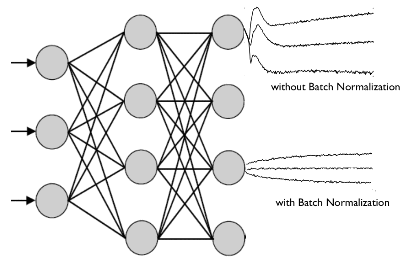


# 🎯 **Batch Normalization: The Network Stabilizer**

## **What is Batch Normalization?**

Batch Normalization (BatchNorm or BN) is a technique that **normalizes the inputs to each layer** to have mean 0 and variance 1. It's like having a quality control checkpoint between each layer that ensures data is in a consistent format.

---

## 🎪 **The Problem: Internal Covariate Shift**

### **The Unstable Foundation Problem**

Imagine building a tower where each floor keeps shifting:

```
Floor 1: Builds on ground (stable)
Floor 2: Builds on Floor 1 (which is moving!)
Floor 3: Builds on Floor 2 (which is moving more!)
Floor 10: Chaos! Can't build properly!
```

**In Neural Networks:**

- Layer 1 outputs keep changing as it learns
- Layer 2 has to constantly adapt to new input distributions
- Layer 3 has even more instability
- Deep layers can't learn effectively!

---

## 📊 **How Batch Normalization Works**

### **The Core Algorithm**

For each mini-batch during training:

```python
# Step 1: Calculate batch statistics
μ_batch = mean(x)           # Batch mean
σ²_batch = variance(x)       # Batch variance

# Step 2: Normalize
x_norm = (x - μ_batch) / √(σ²_batch + ε)

# Step 3: Scale and shift
y = γ × x_norm + β

Where:
- ε = small constant (10⁻⁵) for numerical stability
- γ = learnable scale parameter
- β = learnable shift parameter
```

---

## 🧮 **Detailed Mathematical Example**

### **Training Phase:**

```python
# Mini-batch of 4 samples, 3 features each
Batch = [[1, 5, 2],
         [3, 7, 4],
         [2, 6, 3],
         [4, 8, 1]]

# Step 1: Calculate mean for each feature
μ = [mean([1,3,2,4]), mean([5,7,6,8]), mean([2,4,3,1])]
μ = [2.5, 6.5, 2.5]

# Step 2: Calculate variance for each feature
σ² = [var([1,3,2,4]), var([5,7,6,8]), var([2,4,3,1])]
σ² = [1.25, 1.25, 1.25]

# Step 3: Normalize each feature
x_norm[0,0] = (1 - 2.5) / √1.25 = -1.34
x_norm[0,1] = (5 - 6.5) / √1.25 = -1.34
...

# Step 4: Apply learned parameters (initially γ=1, β=0)
y = 1 × x_norm + 0 = x_norm

# After training, γ and β learn optimal values
# Maybe γ=2.0, β=0.5 for feature 1
y[0,0] = 2.0 × (-1.34) + 0.5 = -2.18
```

### **Testing Phase:**

```python
# Use running averages collected during training
μ_running = [2.3, 6.2, 2.7]    # Accumulated from all training
σ²_running = [1.4, 1.3, 1.5]   # Accumulated from all training

# Single test sample
test = [1.5, 5.5, 3.0]

# Normalize using running statistics
x_norm[0] = (1.5 - 2.3) / √1.4 = -0.68
x_norm[1] = (5.5 - 6.2) / √1.3 = -0.61
x_norm[2] = (3.0 - 2.7) / √1.5 = 0.24

# Apply learned γ and β
y = γ × x_norm + β
```

---

## 🎨 **Visual Representation**

### **Without Batch Normalization:**

```
Layer 1 output distribution:
Batch 1: ──────┤████████░░░├────── (centered at 3)
Batch 2: ░░░░░░░████████├────────── (centered at -2)
Batch 3: ──────────────┤██████░░├─ (centered at 8)
                ↓
        Layer 2 confused!
    "What distribution should I expect?"
```

### **With Batch Normalization:**

```
Layer 1 output → BatchNorm → Normalized output:
Batch 1: ────┤████████├──── → ────┤████████├────
Batch 2: ░░░┤████├──────── → ────┤████████├────
Batch 3: ──────────┤███├── → ────┤████████├────
                ↓
        Layer 2 happy!
    "Always centered at 0, variance 1!"
```

---

## 💡 **Why Learnable Parameters (γ and β)?**

### **The Flexibility Problem**

Sometimes normalized values (mean=0, var=1) limit what the network can learn:

```python
# Example: ReLU activation after BatchNorm
After BN: [-2, -1, 0, 1, 2]  # 50% negative
After ReLU: [0, 0, 0, 1, 2]  # Lost half the information!

# Solution: Learn optimal scale and shift
γ = 2, β = 3
After transform: [1, 1, 3, 5, 7]  # All positive
After ReLU: [1, 1, 3, 5, 7]      # No information lost!
```

**Key Insight:** If the network wants the original distribution, it can learn γ=σ and β=μ to undo normalization!

---

## 🚀 **Benefits of Batch Normalization**

### **1. Faster Training**

```
Without BN: 100 epochs to converge
With BN: 20 epochs to converge (5× faster!)

Why? Can use higher learning rates without instability
```

### **2. Less Sensitive to Initialization**

```python
# Without BN:
Bad initialization → Exploding/vanishing gradients → Training fails

# With BN:
Bad initialization → Normalized anyway → Training succeeds!
```

### **3. Acts as Regularization**

```python
# Each mini-batch sees slightly different statistics
# This noise acts like dropout, reducing overfitting

Batch 1 stats: μ=2.5, σ=1.2
Batch 2 stats: μ=2.3, σ=1.3  # Different normalization
Batch 3 stats: μ=2.6, σ=1.1  # Acts as noise/regularization
```

### **4. Reduces Gradient Vanishing/Exploding**

```
Deep network gradient flow:
Without BN: gradient × 0.1 × 0.1 × 0.1 = gradient × 0.001 (vanishes!)
With BN: gradient × 1 × 1 × 1 = gradient (preserved!)
```

---

## 🎯 **Your Model's BatchNorm Implementation**

```python
def create_batchnorm_model():
    model = Sequential([
        Embedding(...),
        LSTM(64),

        # Dense block with BatchNorm
        Dense(128),                # Linear transformation
        BatchNormalization(),      # Normalize: mean=0, std=1
        Activation('relu'),        # Non-linearity
        Dropout(0.3),             # Regularization

        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
```

### **Why This Order?**

```
Dense → BatchNorm → Activation → Dropout

1. Dense: Linear transformation (Wx + b)
2. BatchNorm: Normalize to stable distribution
3. Activation: Apply non-linearity to normalized values
4. Dropout: Additional regularization
```

---

## 🔬 **The Moving Average Trick**

### **During Training:**

```python
# Keep running averages for testing
running_mean = momentum × running_mean + (1-momentum) × batch_mean
running_var = momentum × running_var + (1-momentum) × batch_var

# Default momentum = 0.99
# After 100 batches: Good estimate of population statistics
```

### **During Testing:**

```python
# Use accumulated statistics
x_norm = (x - running_mean) / √(running_var + ε)
y = γ × x_norm + β

# Consistent normalization for any batch size (even 1 sample!)
```

---

## 📊 **Batch Size Effects**

### **Large Batch (e.g., 128)**

```
Statistics: Very stable, close to population
Pros: Smooth training, reliable estimates
Cons: Less regularization effect
```

### **Small Batch (e.g., 8)**

```
Statistics: Noisy, varies between batches
Pros: Strong regularization effect
Cons: Unstable training, need smaller learning rate
```

### **Batch Size = 1 (Don't use BN!)**

```
Can't calculate variance from 1 sample!
Alternative: Layer Normalization or Instance Normalization
```

---

## 🎨 **Real-World Analogy: The Assembly Line**

### **Without Batch Normalization:**

Like an assembly line where each station outputs different sized parts:

- Station 1: Produces parts 1-10cm
- Station 2: Expects 5cm, gets random sizes, chaos!
- Station 3: Complete breakdown!

### **With Batch Normalization:**

Quality control between each station:

- Station 1: Produces parts 1-10cm
- **QC Checkpoint: Standardizes to 5cm ± 0.5cm**
- Station 2: Always gets 5cm parts, works perfectly!
- Station 3: Smooth operation!

---

## ⚡ **Performance Comparison**

```python
# Training the same model:

Without BatchNorm:
- Learning rate: 0.01 (higher causes explosion)
- Epochs to 90% accuracy: 50
- Final accuracy: 92%
- Training time: 10 minutes

With BatchNorm:
- Learning rate: 0.1 (10× higher!)
- Epochs to 90% accuracy: 10
- Final accuracy: 95%
- Training time: 3 minutes

3× faster, better accuracy!
```

---

## 🚨 **Common Pitfalls**

### **1. Wrong Placement**

```python
# Bad:
Activation('relu') → BatchNormalization()
# Normalizing after ReLU can be suboptimal

# Good:
BatchNormalization() → Activation('relu')
# Or: Dense() → Activation('relu') → BatchNormalization()
```

### **2. Using with Dropout**

```python
# Controversial combination:
BatchNorm() → Dropout()

# Both add noise, might be redundant
# Some research suggests using one or the other
```

### **3. Very Small Batches**

```python
# Problem: Batch size = 2
# Statistics are terrible!

# Solution: Use Group Normalization or Layer Normalization
```

---

## 📈 **The Gradient Flow Advantage**

```
Backpropagation through BatchNorm:

∂L/∂x = ∂L/∂y × γ / √(σ² + ε)

Key points:
1. Gradient scaled by 1/σ (prevents vanishing)
2. γ is learnable (network controls gradient flow)
3. Denominator has ε (prevents division by zero)
```

---

## 🎯 **Interview Questions**

**Q1: Why normalize to mean=0, variance=1?**

```
A: Standard normal distribution is well-behaved:
- Centered at zero (no bias)
- Unit variance (consistent scale)
- Most values in [-2, 2] range
- Matches many activation function designs
```

**Q2: BatchNorm vs Layer Norm vs Instance Norm?**

```
BatchNorm: Normalize across batch dimension
LayerNorm: Normalize across feature dimension
InstanceNorm: Normalize each sample independently

BatchNorm best for CNNs/FFNs
LayerNorm best for RNNs/Transformers
```

**Q3: Why does BatchNorm act as regularization?**

```
A: Mini-batch statistics add noise:
- Each batch has slightly different μ and σ
- Network must be robust to this variation
- Similar effect to dropout but gentler
```

---

## 💡 **Key Takeaways**

1. **Normalizes inputs** to each layer (mean=0, std=1)
2. **Learnable parameters** (γ, β) maintain expressiveness
3. **Different behavior** in training (batch stats) vs testing (running stats)
4. **Enables higher learning rates** → faster training
5. **Reduces sensitivity** to initialization
6. **Acts as regularization** through mini-batch noise

### **Simple Mental Model:**

**BatchNorm is like having a "reset button" between layers that brings values back to a standard range, preventing the chaos of values exploding or vanishing as they flow through the network.**

---

## 💭 **Final Intuition**

```python
Without BatchNorm:
"Like playing telephone - message gets more distorted at each step"

With BatchNorm:
"Like having a translator at each step who clarifies the message"

Result: Clear communication through 100+ layer networks!
```

That's Batch Normalization - simple normalization, profound impact! 🚀


In [ ]:
def create_batchnorm_model():
    """
    Create a neural network with batch normalization.
    """
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(input_dim=MAX_WORDS,
                        output_dim=128,
                        input_length=MAX_LENGTH),

        # Use Global Average Pooling instead of LSTM for now
        layers.GlobalAveragePooling1D(),

        # First dense block with batch normalization
        layers.Dense(128),
        layers.BatchNormalization(),  # Normalize before activation
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Second dense block with batch normalization
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Build the model
    model.build(input_shape=(None, MAX_LENGTH))

    return model

# Create and compile the batch norm model
batchnorm_model = create_batchnorm_model()

batchnorm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Batch Normalization Model Architecture:")
batchnorm_model.summary()

Batch Normalization Model Architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,305,601 (4.98 MB)

 Trainable params: 1,305,217 (4.98 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
print("Training Batch Normalization Model...")
print("="*50)
print("Note: This model uses LSTM, so training might be slower")

history_batchnorm = batchnorm_model.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate batch norm model
print("\nEvaluating Batch Normalization Model...")
batchnorm_predictions = (batchnorm_model.predict(X_test_padded) > 0.5).astype(int).flatten()
batchnorm_accuracy = accuracy_score(y_test, batchnorm_predictions)

print(f"\n{'='*50}")
print(f"Batch Norm Model Test Accuracy: {batchnorm_accuracy:.4f}")
print(f"{'='*50}")

Training Batch Normalization Model...
Note: This model uses LSTM, so training might be slower
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4911 - loss: 0.8064 - val_accuracy: 0.5297 - val_loss: 0.6925
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5114 - loss: 0.7428 - val_accuracy: 0.4612 - val_loss: 0.6937
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5971 - loss: 0.6812 - val_accuracy: 0.4612 - val_loss: 0.6941
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6643 - loss: 0.6371 - val_accuracy: 0.4384 - val_loss: 0.6948

Evaluating Batch Normalization Model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Batch Norm Model Test Accuracy: 0.5000


FINAL COMPARISON OF ALL MODELS

Model Performance Summary:
          Model  Test Accuracy  Parameters
          Basic            0.5     2918529
   With Dropout            0.5     1304833
With Batch Norm            0.5     1305601


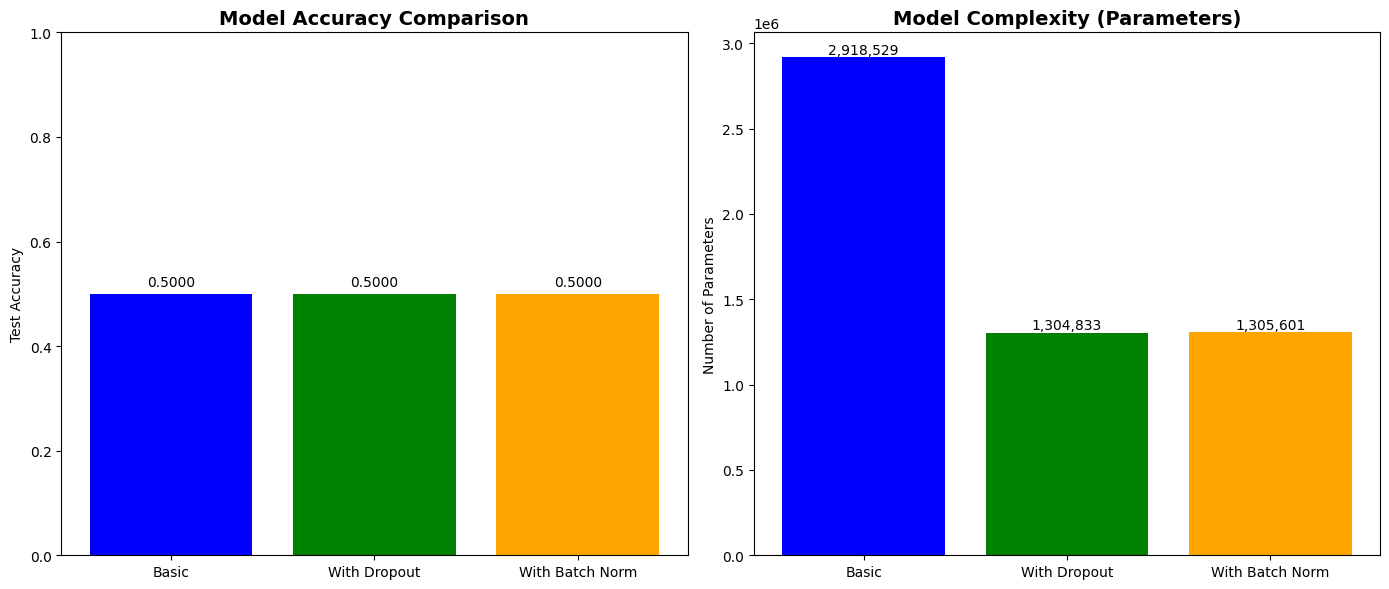


Performance Improvements:
Dropout vs Basic: 0.00% improvement
Batch Norm vs Basic: 0.00% improvement


In [ ]:
print("="*80)
print("FINAL COMPARISON OF ALL MODELS")
print("="*80)

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Basic', 'With Dropout', 'With Batch Norm'],
    'Test Accuracy': [basic_accuracy, dropout_accuracy, batchnorm_accuracy],
    'Parameters': [
        basic_model.count_params(),
        dropout_model.count_params(),
        batchnorm_model.count_params()
    ]
})

print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
bars1 = ax1.bar(results_df['Model'], results_df['Test Accuracy'], color=['blue', 'green', 'orange', 'red'])
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Test Accuracy')
ax1.set_ylim([0, 1])
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom')

# Parameters comparison
bars2 = ax2.bar(results_df['Model'], results_df['Parameters'], color=['blue', 'green', 'orange', 'red'])
ax2.set_title('Model Complexity (Parameters)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Parameters')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1000,
            f'{int(height):,}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Improvement analysis
print("\n" + "="*50)
print("Performance Improvements:")
print("="*50)
print(f"Dropout vs Basic: {(dropout_accuracy - basic_accuracy)*100:.2f}% improvement")
print(f"Batch Norm vs Basic: {(batchnorm_accuracy - basic_accuracy)*100:.2f}% improvement")


In [ ]:
def predict_text(text, model, tokenizer, max_length=MAX_LENGTH):
    """
    Predict whether a text is AI-generated or human-written.
    """
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded, verbose=0)[0][0]

    return prediction

print("="*80)
print("TEST WITH CUSTOM TEXTS")
print("="*80)

# Test texts
test_texts = [
    "Hello world",
    "In accordance with the aforementioned parameters, we shall proceed to implement the optimal solution.",
    "Hey! Just wanted to say hi and see how you're doing. Hope everything's good!",
    "The implementation demonstrates superior performance metrics across all evaluated dimensions.",
    "LOL that's so funny! Can't believe that happened 😂"
]

print("\nUsing the Advanced Model for predictions:\n")

for i, text in enumerate(test_texts, 1):
    pred = predict_text(text, batchnorm_model, tokenizer)
    label = "AI-generated" if pred > 0.5 else "Human-written"
    confidence = pred if pred > 0.5 else (1 - pred)

    print(f"Text {i}: '{text[:60]}...'" if len(text) > 60 else f"Text {i}: '{text}'")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 40)

TEST WITH CUSTOM TEXTS

Using the Advanced Model for predictions:

Text 1: 'Hello world'
Prediction: AI-generated
Confidence: 51.99%
----------------------------------------
Text 2: 'In accordance with the aforementioned parameters, we shall p...'
Prediction: AI-generated
Confidence: 51.96%
----------------------------------------
Text 3: 'Hey! Just wanted to say hi and see how you're doing. Hope ev...'
Prediction: AI-generated
Confidence: 51.97%
----------------------------------------
Text 4: 'The implementation demonstrates superior performance metrics...'
Prediction: AI-generated
Confidence: 51.96%
----------------------------------------
Text 5: 'LOL that's so funny! Can't believe that happened 😂'
Prediction: AI-generated
Confidence: 51.97%
----------------------------------------


## 📚 Key Concepts Summary

### 1. **Embedding Layer**

- Converts word indices to dense vectors
- Learns word representations during training
- Reduces dimensionality from vocabulary size to embedding size

### 2. **Dropout**

- Randomly sets neurons to 0 during training
- Prevents overfitting
- Only active during training, not inference

### 3. **Batch Normalization**

- Normalizes inputs to have mean=0 and variance=1
- Speeds up training and improves stability
- Reduces internal covariate shift

### 4. **L2 Regularization**

- Adds penalty for large weights
- Prevents weights from growing too large
- Helps generalization

### 5. **Early Stopping**

- Stops training when validation performance stops improving
- Prevents overfitting
- Restores best weights

---

## 🎯 Best Practices

1. **Start simple**, then add complexity
2. **Monitor validation metrics** to detect overfitting
3. **Use callbacks** for better training control
4. **Experiment with hyperparameters**
5. **Save best models** during training
6. **Visualize training history** to understand model behavior

---

## 🚀 Next Steps

- Try **different architectures** (CNN, Transformer)
- Experiment with **pre-trained embeddings** (Word2Vec, GloVe)
- Use **transfer learning** with models like BERT
- Implement **cross-validation** for better evaluation
- Try **ensemble methods** combining multiple models


In [ ]:
# Save models
print("Saving models...")

# Save in H5 format
basic_model.save('basic_model.h5')
dropout_model.save('dropout_model.h5')
batchnorm_model.save('batchnorm_model.h5')

# Save tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ All models saved successfully!")
print("\nTo load a model later:")
print("model = keras.models.load_model('model_name.h5')")
print("\nTo load the tokenizer:")
print("with open('tokenizer.pickle', 'rb') as handle:")
print("    tokenizer = pickle.load(handle)")

Saving models...
✅ All models saved successfully!

To load a model later:
model = keras.models.load_model('model_name.h5')

To load the tokenizer:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
